### News Category Classification using Simple RNN

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam


Applying feature engineering techniques like lower casing the words, removing stop words and then applying lemmatization to improve the model performance and accuracy

In [3]:
# removing stopwords and applying lemmatization on sentences
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# Loading the datasets
train_dataset = pd.read_csv('/content/sample_data/train.csv') #change the path according to your directory
test_dataset = pd.read_csv('/content/sample_data/test.csv') #change the path according to your directory

# making class labels to 0-indexed
train_dataset['Class Index'] = train_dataset['Class Index'] - 1
test_dataset['Class Index'] = test_dataset['Class Index'] - 1

x_train = train_dataset[['Title', 'Description']]
y_train = train_dataset['Class Index']
x_test = test_dataset[['Title', 'Description']]
y_test = test_dataset['Class Index']

y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

# preprocessing steps for each sentences
def combine_text(title, description):
    title_str = str(title) if pd.notna(title) else ""
    description_str = str(description) if pd.notna(description) else ""
    combined = f"{title_str} {description_str}".strip()
    return preprocess_text(combined)

x_train_combined = [combine_text(row['Title'], row['Description']) for _, row in x_train.iterrows()]
x_test_combined = [combine_text(row['Title'], row['Description']) for _, row in x_test.iterrows()]

print(f'Total training sentences: {len(x_train_combined)}')
print(f'Total test sentences: {len(x_test_combined)}')

Total training sentences: 120000
Total test sentences: 7600


- To determine the maximum sentence length inside the training dataset which helps to convert all the sentences to fix dimension by applying pre padding and removing post padding in case of longer sentences
- According to a research paper, the size of the sentence should cover 90-95% of the sentences length
- converting all the sentences into same dimensions

In [5]:
def get_95th_percentile_length(texts):
    sentence_lengths = [len(text.split()) for text in texts]
    percentile_95 = np.percentile(sentence_lengths, 95)
    return int(percentile_95)
percentile_95_length = get_95th_percentile_length(x_train_combined)
print(f"95th percentile sentence length: {percentile_95_length}")

95th percentile sentence length: 34


In [6]:
# applying tokenization and preprocessing techniques
vocab_size = 15000
max_sent_length = percentile_95_length
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_combined)

x_train_sequences = tokenizer.texts_to_sequences(x_train_combined)
x_test_sequences = tokenizer.texts_to_sequences(x_test_combined)

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sent_length, padding='pre', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_sent_length, padding='pre', truncating='post')

print(f"\nPadded sequences shape - Train: {x_train_padded.shape}, Test: {x_test_padded.shape}")

# converting labels into numerice vectors
label_encoder = LabelEncoder()
label_encoder.fit(train_dataset['Class Index'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")



Padded sequences shape - Train: (120000, 34), Test: (7600, 34)
Number of classes: 4


In [7]:
# building the SimpleRNN Model
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_sent_length,)),
    SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.build(input_shape=(None, max_sent_length))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 34, 100)        │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537,828 (5.87 MB)

 Trainable params: 1,537,828 (5.87 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 40ms/step - accuracy: 0.2510 - loss: 1.4150 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.2522 - loss: 1.3919 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.2924 - loss: 1.3319 - val_accuracy: 0.6605 - val_loss: 0.7129
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.7307 - loss: 0.6497 - val_accuracy: 0.8684 - val_loss: 0.4115
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.8584 - loss: 0.4548 - val_accuracy: 0.8775 - val_loss: 0.3996
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.8750 - loss: 0.4178 - val_accuracy: 0.8808 - val_loss: 0.3881
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - accuracy: 0.8863 - loss: 0.3889 - val_accuracy: 0.8743 - val_loss: 0.4009
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/st

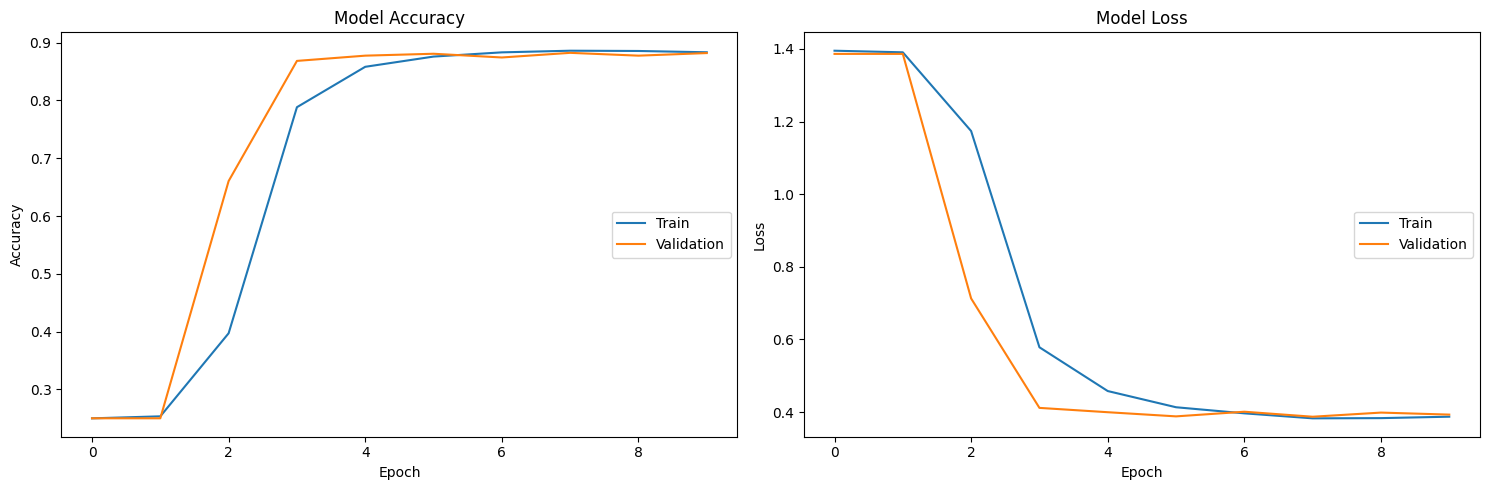


Final Training Accuracy: 91.08%
Final Test Accuracy: 88.20%


In [8]:
# training the RNN model
batch_size = 64
epochs = 10

print("\nTraining the model...")
history = model.fit(
    x_train_padded, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_padded, y_test),
    verbose=1,
    shuffle=True
) # keeping shuffle as True to improve the model performance

# evaluting the model
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')

plt.tight_layout()
plt.show()

# Evaluate the model
train_loss, train_acc = model.evaluate(x_train_padded, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test_padded, y_test, verbose=0)

print(f"\nFinal Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
                precision    recall  f1-score   support

         World       0.93      0.84      0.89      1900
        Sports       0.92      0.97      0.95      1900
      Business       0.82      0.85      0.83      1900
Science & Tech       0.86      0.87      0.87      1900

      accuracy                           0.88      7600
     macro avg       0.88      0.88      0.88      7600
  weighted avg       0.88      0.88      0.88      7600



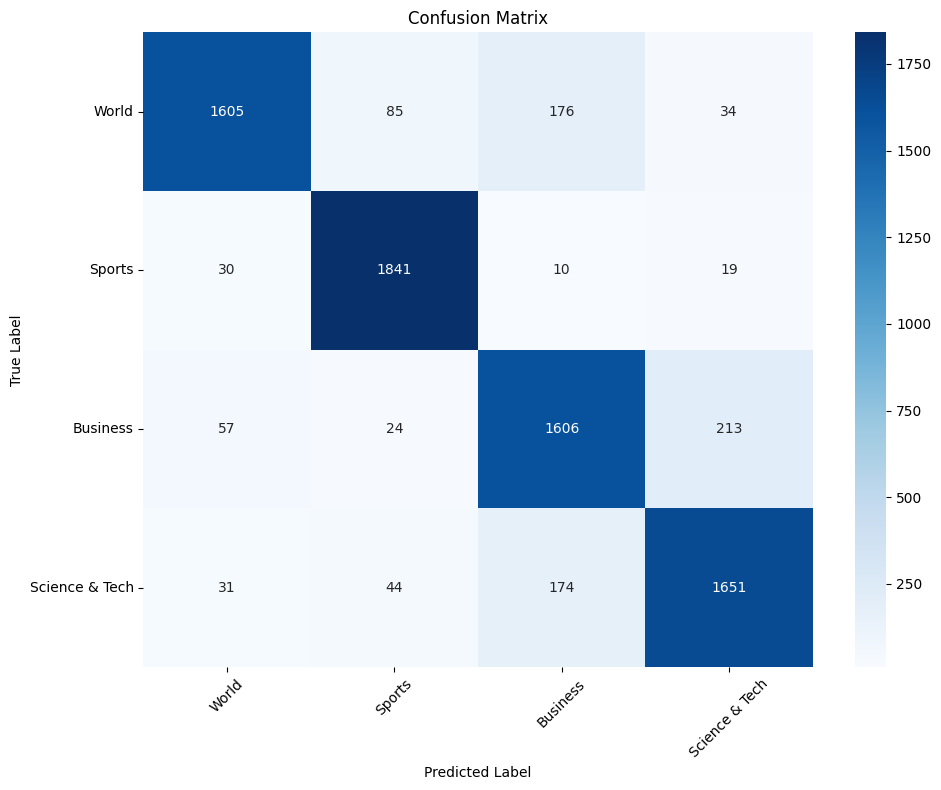

In [9]:
# classification Report
y_pred_probs = model.predict(x_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = ['World','Sports','Business','Science & Tech']
original_class_names = [f'{class_name}' for class_name in class_names]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=original_class_names))

# confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_class_names,
            yticklabels=original_class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
import pickle
# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save model separately
model.save("news_classification_simple_rnn_model.h5")

In [11]:
# from google.colab import files
# files.download('news_simple_rnn_model.h5')